 # MTH8408 : Méthodes d'optimisation et contrôle optimal
 ## Laboratoire 2: Optimisation sans contraintes
Tangi Migot

In [1]:
using ADNLPModels, LinearAlgebra, NLPModels, Printf

[ Info: Precompiling ADNLPModels [54578032-b7ea-4c30-94aa-7cbd1cce6c9a]


On pourra trouver de la documentation sur `ADNLPModels` et `NLPModels` ici:
- [juliasmoothoptimizers.github.io/NLPModels.jl/dev/](https://juliasmoothoptimizers.github.io/NLPModels.jl/dev/)
- [juliasmoothoptimizers.github.io/ADNLPModels.jl/dev/](https://juliasmoothoptimizers.github.io/ADNLPModels.jl/dev/)

In [2]:
# Problème test:
f(x) = x[1]^2 * (2*x[1] - 3) - 6*x[1]*x[2] * (x[1] - x[2] - 1) # fonction objectif vue en classe
g(x) = 6 * [x[1]^2 - x[1] - 2*x[1]*x[2] + x[2]^2 + x[2]; -x[1]^2 + 2*x[1]*x[2] + x[1]] # le gradient de f
H(x) = 6 * [2*x[1]-1-2*x[2] -2*x[1]+2*x[2]+1; -2*x[1]+2*x[2]+1 2*x[1]] # la Hessienne de f

H (generic function with 1 method)

### Exercice 1: Newton avec recherche linéaire - amélioration du code

Ci-dessous, vous avez le code de deux fonctions qui ont été vues dans le cours, la recherche linéaire qui satisfait Armijo, et une méthode de Newton avec cette recherche linéaire. Le but de ce laboratoire est d'implémenter d'autres méthodes utiles pour résoudre des problèmes de grandes dimensions.

In [3]:
#Amélioration possibles: return also the value of f
function armijo(xk, dk, fk, gk, f)
  slope = dot(gk, dk) #doit être <0
  t = 1.0
  while f(xk + t * dk) > fk + 1.0e-4 * t * slope
    t /= 1.5
  end
  return t
end

armijo (generic function with 1 method)

In [ ]:
#Test pour vérifier que la fonction armijo fonctionne correctement.
using Test #le package Test définit (entre autre) la macro @test qui permet de faire des tests unitaires :-)
xk = ones(2)
gk = g(xk)
dk = - gk
fk = f(xk)
t  = armijo(xk, dk, fk, gk, f)
@test t < 1
@test f(xk + t * dk) <= fk + 1.0e-4 * t * dot(gk,dk)

xk = [1.5, 0.5]
fk = f(xk)
gk = g(xk)
dk = - gk
t  = armijo(xk, dk, fk, gk, f)
@test t < 1
@test f(xk + t * dk) <= f(xk) + 1.0e-4 * t * dot(g(xk),dk)


In [4]:
function newton_armijo(f, g, H, x0; verbose::Bool = true)
  xk  = x0
  fk  = f(xk)
  gk = g(xk)
  gnorm = gnorm0 = norm(gk)
  k = 0
  verbose && @printf "%2s %9s %9s\n" "k" "fk" "||∇f(x)||"
  verbose && @printf "%2d %9.2e %9.1e\n" k fk gnorm
  while gnorm > 1.0e-6 + 1.0e-6 * gnorm0 && k < 100
    Hk = H(xk)
    dk = - Hk \ gk
    slope = dot(dk, gk)
    λ = 0.0
    while slope ≥ -1.0e-4 * norm(dk) * gnorm
      λ = max(1.0e-3, 10 * λ)
      dk = - ((Hk + λ * I ) \ gk)
      slope = dot(dk, gk)
    end
    t = armijo(xk, dk, fk, gk, f)
    xk += t * dk
    fk = f(xk)
    gk = g(xk)
    gnorm = norm(gk)
    k += 1
    verbose && @printf "%2d %9.2e %9.1e %7.1e \n" k fk gnorm t
  end
  return xk
end

newton_armijo (generic function with 1 method)

In [5]:
sol = newton_armijo(f, g, H, [.5, .5])
@test g(sol) ≈ zeros(2) atol = 1.0e-6

 k        fk ||∇f(x)||
 0  1.00e+00   4.5e+00
 1  5.08e-02   8.4e-01 1.0e+00 
 2  4.73e-04   7.6e-02 1.0e+00 
 3  6.97e-08   9.1e-04 1.0e+00 
 4  1.62e-15   1.4e-07 1.0e+00 


LoadError: LoadError: UndefVarError: @test not defined
in expression starting at In[5]:2

On veut améliorer le code de la fonction `newton_armijo` avec les ajouts suivants:
- Changer les paramètre d'entrées de la fonction pour un `nlp`
- Avant d'appeler la recherche linéaire, si `slope = dot(dk, gk)` est plus grand que `-1.0e-4 * norm(dk) * gnorm`, on modifie le système. On fait maximum 5 mise à jour de `λ`, sinon on prend l'opposé du gradient.
```
    λ = 0.0
    while slope ≥ -1.0e-4 * norm(dk) * gnorm
      λ = max(1.0e-3, 10 * λ)
      dk = - ((Hk + λ * I ) \ gk)
      slope = dot(dk, gk)
    end
```
Ajouter un compteur sur le nombre de mises à jour de `λ` et ajuster `dk = - gk` si la limite est atteinte.
- On veut aussi détecter et éventuellement arrêter la boucle `while` si la fonction objectif `fk` devient trop petite/négative (inférieure à `-1e15`), i.e. le problème est non-bornée inférieurement.
- On veut ajouter deux critères d'arrêts supplémentaires: 
  - un compteur sur le nombre d'évaluations de f (maximum 1000). Utiliser `neval_obj(nlp)`.
  -  une limite de temps d'execution, `max_time = 60.0`. Utiliser la fonction `time()`.
- Enfin, on voudrait aussi voir un message à l'écran si l'algorithme n'a pas trouvé la solution, i.e. il s'est arrêté à cause de la limite sur le nombre d'itérations, temps, évaluation de fonctions, problème non-borné.

In [6]:
#SOLUTION: fonction à modifier
function newton_armijo(nlp, x0; verbose::Bool = true)
  xk  = x0
  fk  = obj(nlp, xk)
  gk = grad(nlp, xk)
  gnorm = gnorm0 = norm(gk)
  k = 0
  verbose && @printf "%2s %9s %9s\n" "k" "fk" "||∇f(x)||"
  verbose && @printf "%2d %9.2e %9.1e\n" k fk gnorm
  while gnorm > 1.0e-6 + 1.0e-6 * gnorm0 && k < 100 && fk > -1e15
    Hk = hess(nlp, xk)
    dk = - Hk \ gk
    slope = dot(dk, gk)
    λ = 0.0
    j = 0
    while slope ≥ -1.0e-4 * norm(dk) * gnorm && (j < 5)
      λ = max(1.0e-3, 10 * λ)
      dk = - ((Hk + λ * I ) \ gk)
      slope = dot(dk, gk)
      j += 1
    end
    if j==5
            dk = -gk
    end
    t = armijo(xk, dk, fk, gk, x -> obj(nlp, x))
    xk += t * dk
    fk = obj(nlp, xk)
    gk = grad(nlp, xk)
    gnorm = norm(gk)
    k += 1
    verbose && @printf "%2d %9.2e %9.1e %7.1e \n" k fk gnorm t
  end
  return xk
end

newton_armijo (generic function with 2 methods)

In [7]:
#Test
f(x) = x[1]^2 * (2*x[1] - 3) - 6*x[1]*x[2] * (x[1] - x[2] - 1)
x0 = zeros(2)
nlp = ADNLPModel(f, x0)

newton_armijo(nlp, x0)

 k        fk ||∇f(x)||
 0  0.00e+00   0.0e+00


2-element Vector{Float64}:
 0.0
 0.0

In [8]:
using Logging, Test
fH(x) = (x[2]+x[1].^2-11).^2+(x[1]+x[2].^2-7).^2
x0H = [10., 20.]
himmelblau = ADNLPModel(fH, x0H)
ep1 = 1e-6 + norm(grad(himmelblau, himmelblau.meta.x0)) * 1e-6
sol = newton_armijo(himmelblau, himmelblau.meta.x0) 
@test norm(grad(himmelblau, sol)) ≤ ep1
@test sol ≈ [3, 2] atol = ep1
@show sol

 k        fk ||∇f(x)||
 0  1.74e+05   3.3e+04
 1  3.35e+04   9.7e+03 1.0e+00 
 2  6.24e+03   2.8e+03 1.0e+00 
 3  1.10e+03   8.2e+02 1.0e+00 
 4  1.81e+02   2.3e+02 1.0e+00 
 5  2.69e+01   6.2e+01 1.0e+00 
 6  2.68e+00   1.5e+01 1.0e+00 
 7  1.00e-01   2.6e+00 1.0e+00 
 8  3.28e-04   1.4e-01 1.0e+00 
 9  4.53e-09   5.3e-04 1.0e+00 
sol = [2.9999960815075677, 2.000017736641731]


2-element Vector{Float64}:
 2.9999960815075677
 2.000017736641731

In [9]:
problem2 = ADNLPModel(x->-x[1]^3 + x[2]^2 + x[3]^2, ones(3))
ep2 = 1e-6 + norm(grad(problem2, problem2.meta.x0)) * 1e-6
sol = newton_armijo(problem2, problem2.meta.x0) 
# @test stats.status == :unbounded
@test obj(problem2, sol) ≤ -1e15
@show sol

 k        fk ||∇f(x)||
 0  1.00e+00   4.1e+00
 1 -1.25e-01   7.5e-01 1.0e+00 
 2 -1.95e+00   4.7e+00 1.0e+00 
 3 -2.09e+02   1.1e+02 1.0e+00 
 4 -1.39e+06   3.7e+04 1.0e+00 
 5 -5.29e+13   4.2e+09 1.0e+00 
 6 -7.56e+28   5.4e+19 1.0e+00 
sol = [4.2282080610520687e9, 0.0, 0.0]


3-element Vector{Float64}:
 4.2282080610520687e9
 0.0
 0.0

In [10]:
roz(x) = 100 *  (x[2] - x[1]^2)^2 + (x[1] - 1.0)^2
rosenbrock = ADNLPModel(roz, [-1.2, 1.0])
ep2 = 1e-6 + norm(grad(rosenbrock, rosenbrock.meta.x0)) * 1e-6
sol = newton_armijo(rosenbrock, rosenbrock.meta.x0) 
@test sol ≈ [1., 1.] atol = ep2
@show sol

 k        fk ||∇f(x)||
 0  2.42e+01   2.3e+02
 1  4.73e+00   4.6e+00 1.0e+00 
 2  4.12e+00   3.1e+01 1.3e-01 
 3  3.22e+00   1.0e+01 1.0e+00 
 4  2.84e+00   2.3e+01 6.7e-01 
 5  2.05e+00   5.1e+00 1.0e+00 
 6  1.73e+00   1.2e+01 4.4e-01 
 7  1.24e+00   3.8e+00 1.0e+00 
 8  1.03e+00   9.5e+00 6.7e-01 
 9  6.69e-01   1.8e+00 1.0e+00 
10  6.08e-01   1.2e+01 6.7e-01 
11  2.95e-01   8.0e-01 1.0e+00 
12  2.13e-01   7.2e+00 4.4e-01 
13  1.07e-01   9.9e-01 1.0e+00 
14  6.57e-02   5.3e+00 6.7e-01 
15  2.50e-02   8.0e-01 1.0e+00 
16  1.35e-02   4.3e+00 1.0e+00 
17  1.35e-03   8.0e-02 1.0e+00 
18  1.45e-04   5.3e-01 1.0e+00 
19  1.77e-07   7.5e-04 1.0e+00 
20  3.16e-12   7.8e-05 1.0e+00 
sol = [0.9999997374059799, 0.9999992988781841]


2-element Vector{Float64}:
 0.9999997374059799
 0.9999992988781841

In [11]:
f(x) = x[1]^2 * (2*x[1] - 3) - 6*x[1]*x[2] * (x[1] - x[2] - 1)
x0 = [-1.001, -1.001]
pb_du_cours = ADNLPModel(f, x0) #ou [1.5, .5] ou [.5, .5]
ep3 = 1e-6 + norm(grad(pb_du_cours, x0)) * 1e-6
sol = newton_armijo(pb_du_cours, x0) 
@test norm(grad(pb_du_cours, sol)) ≤ ep3 || obj(pb_du_cours, sol) <= -1e15

 k        fk ||∇f(x)||
 0  1.00e+00   6.0e-03
 1  1.00e+00   8.6e-02 1.0e+00 
 2  9.37e-01   1.3e+00 1.0e+00 
 3 -4.66e+00   1.3e+01 1.0e+00 
 4 -1.14e+03   3.5e+02 1.0e+00 
 5 -4.11e+07   5.4e+05 1.0e+00 
 6 -5.52e+16   3.1e+11 1.0e+00 


Test Passed

In [12]:
# Tests secrets 1: contactez votre professeur pour avoir ces tests additionels si vous êtes prêt.
using Test

@testset "Test set for newton_armijo" begin
	#Test problem:
	fH(x) = (x[2]+x[1].^2-11).^2+(x[1]+x[2].^2-7).^2
	x0H = [10., 20.]
	himmelblau = ADNLPModel(fH, x0H)

	problem2 = ADNLPModel(x->-x[1]^3 + x[2]^2 + x[3]^2, ones(3))

	roz(x) = 100 *  (x[2] - x[1]^2)^2 + (x[1] - 1.0)^2
	rosenbrock = ADNLPModel(roz, [-1.2, 1.0])

	f(x) = x[1]^2 * (2*x[1] - 3) - 6*x[1]*x[2] * (x[1] - x[2] - 1)
	pb_du_cours = ADNLPModel(f, [-1.001, -1.001]) #ou [1.5, .5] ou [.5, .5]


	######################################### newton_armijo ##################

    #=
    Vérifiez que vous pouvez mettre une limite de temps de 1s.
    Puis faites tournez votre algorithme sur un des probléme test.
    L'algorithme devrait s'arrêter en environ 1sec.

    Vérifiez que vous pouvez mettre une limite de 2 évaluations d'objectif.
    Puis faites tournez votre algorithme sur un des probléme test.
    L'algorithme devrait s'arrêter en environ 1 itération.
    =#

	#Unit/Validation Tests
    ep1 = 1e-6 + norm(grad(himmelblau, himmelblau.meta.x0)) * 1e-6
	sol = newton_armijo(himmelblau, himmelblau.meta.x0, verbose = false) 
	@test norm(grad(himmelblau, sol)) ≤ ep1
	@test sol ≈ [3, 2] atol = ep1

    ep2 = 1e-6 + norm(grad(problem2, problem2.meta.x0)) * 1e-6
	sol =  newton_armijo(problem2, problem2.meta.x0, verbose = false) 
	# @test stats.status == :unbounded
    @test obj(problem2, sol) ≤ -1e15

    ep2 = 1e-6 + norm(grad(rosenbrock, rosenbrock.meta.x0)) * 1e-6
	sol = newton_armijo(rosenbrock, rosenbrock.meta.x0, verbose = false) 
	@test sol ≈ [1., 1.] atol = ep2

    ep3 = 1e-6 + norm(grad(pb_du_cours, [-1.001, -1.001])) * 1e-6
	sol = newton_armijo(pb_du_cours, [-1.001, -1.001], verbose = false) 
	@test norm(grad(pb_du_cours, sol)) ≤ ep3 || obj(pb_du_cours, sol) <= -1e15

    ep4 = 1e-6 + norm(grad(pb_du_cours, [1.5, .5])) * 1e-6
	sol = newton_armijo(pb_du_cours, [1.5, .5], verbose = false) 
	@test norm(grad(pb_du_cours, sol)) ≤ ep4 || obj(pb_du_cours, sol) <= -1e15

    ep5 = 1e-6 + norm(grad(pb_du_cours, [.5, .5])) * 1e-6
	sol = newton_armijo(pb_du_cours, [.5, .5], verbose = false) 
	@test norm(grad(pb_du_cours, sol)) ≤ ep5 || obj(pb_du_cours, sol) <= -1e15
end

Test Summary:              | Pass  Total  Time
Test set for newton_armijo |    7      7  1.1s


Test.DefaultTestSet("Test set for newton_armijo", Any[], 7, false, false, true, 1.675817896878e9, 1.675817898012e9)

### Exercice 2: LDLt-Newton avec recherche linéaire

On va maintenant modifier la méthode de Newton vu précédemment pour utiliser un package qui s'occupe de calculer une factorisation de la matrice hessienne tel que:
$$
\nabla^2 f(x) = LDL^T.
$$
Ce type de factorisation n'est possible que si la matrice hessienne est définie positive, dans le cas contraire on a besoin de régularisé le système comme dans l'exercice précédent.

Pour résoudre le système linéaire en utilisant cette factorisation, on va utiliser le package [`LDLFactorizations`](https://github.com/JuliaSmoothOptimizers/LDLFactorizations.jl):

In [13]:
using LDLFactorizations, LinearAlgebra

Un tutoriel sur l'utilisation de `LDLFactorizations` est disponible sur la documentation du package sur github ou encore [à ce lien](https://juliasmoothoptimizers.github.io/LDLFactorizations.jl/dev/tutorial/).

Voici un exemple d'utilisation de ce package. La matrice dont on veut calculer la factorisation doit être de type `Symmetric`.

In [14]:
A = ones(2,2) #cette matrice symétrique, mais pas du type Symmetric
              #à noter que cette matrice n'est pas définie positive.
typeof(A) <: Symmetric #false
A = Symmetric(A)
typeof(A) <: Symmetric #true :)

true

Deuxième étape, le package fait une phase d'analyse de la matrice avec `ldl_analyze` en créant une structure pratique pour les diverses fonctions du package.

In [15]:
A = -rand(2, 2)
sol = rand(2)
b = A*sol #on veut résoudre le système A*x=b

# LDLFactorizations va en réalité demander la matrice triangulaire supérieure
A = Symmetric(triu(A), :U)
S = ldl_analyze(A)
ldl_factorize!(A, S)
x = S \ b # x = A \b ça va être résolu par Julia 
norm(A * x - b)

1.1102230246251565e-16

In [16]:
A = [0. 1.; 1. 0.]

2×2 Matrix{Float64}:
 0.0  1.0
 1.0  0.0

In [17]:
A = Symmetric(triu(A), :U)
S = ldl_analyze(A)
ldl_factorize!(A, S)

LDLFactorizations.LDLFactorization{Float64, Int64, Int64, Int64}(true, false, true, 2, [2, -1], [0, 0], [1, 2], [1, 2], [1, 2], [1, 2, 2], [1, 1, 1], Int64[], [3], [0.0], [0.0, 8.11747406e-316], [0.0, 8.1174373e-316], [0, 3135826977], 0.0, 0.0, 0.0, 2)

In [18]:
S.d

2-element Vector{Float64}:
 0.0
 8.11747406e-316

La matrice `A` factorisée par $LDL^T$ n'était pas forcément définie positive. On peut le voir sur les valeurs de $D$.

In [19]:
S.d #c'est le vecteur qui correspond à la matrice diagonale D.

2-element Vector{Float64}:
 0.0
 8.11747406e-316

Pour l'optimisation, dans le cas où des valeurs de $D$ sont négatives, i.e. `minimum(S.d) <= 0.`, on ajoutera une correction pour être sûr d'obtenir une direction de descente. On pourra choisir un des deux:
- `S.d   = abs.(S.d)` #la valeur absolue des valeurs négatives
- `S.d .+= minimum(S.d) + epsilon`

`LDLFactorizations` a une façon automatique d'utiliser la deuxième option, il suffit de modifier la structure `S` obtenue par `ldl_analyze` avant la factorisation:
```
S.tol = 1e-8 #régularise les valeurs plus petites que cette tolérance
S.n_d = 0 #taille de la régularisation
S.r1 = -eps()^(1/4)
S.r2 = eps()^(1/2)
```

#### Utiliser cette technique pour calculer la direction de descente:

In [20]:
# Solution: copier-coller votre newton_armijo ici et modifier le calcul de la direction avec LDLFactorizations
function newton_ldlt_armijo(nlp, x0; verbose::Bool = true)
  xk  = x0
  fk  = obj(nlp, xk)
  gk = grad(nlp, xk)
  gnorm = gnorm0 = norm(gk)
  k = 0
  verbose && @printf "%2s %9s %9s\n" "k" "fk" "||∇f(x)||"
  verbose && @printf "%2d %9.2e %9.1e\n" k fk gnorm
  while gnorm > 1.0e-6 + 1.0e-6 * gnorm0 && k < 100 && fk > -1e15
    Hk = Symmetric(triu(hess(nlp, xk)), :U)
    Sk = ldl_analyze(Hk)
    # Sk.tol = 1e-8 #régularise les valeurs plus petites que cette tolérance
    # Sk.n_d = 10 #taille de la régularisation
    # Sk.r1 = eps()^(1/4)
    # Sk.r2 = eps()^(1/2)
    ldl_factorize!(Hk, Sk)
    if minimum(Sk.d) < 0
      Sk.d .+= -minimum(Sk.d) + 1e-6 # abs.(Sk.d) #
    end
    dk = - Sk \ gk
    slope = dot(dk, gk)
    t = armijo(xk, dk, fk, gk, x -> obj(nlp, x))
    xk += t * dk
    fk = obj(nlp, xk)
    gk = grad(nlp, xk)
    gnorm = norm(gk)
    k += 1
    verbose && @printf "%2d %9.2e %9.1e %7.1e \n" k fk gnorm t
  end
  return xk
end

newton_ldlt_armijo (generic function with 1 method)

In [21]:
f(x) = x[1]*x[2] + x[1]^4 + x[2]^4
x0 = ones(2)
nlp = ADNLPModel(f, x0)

newton_ldlt_armijo(nlp, x0)

 k        fk ||∇f(x)||
 0  3.00e+00   7.1e+00
 1  6.66e-01   2.2e+00 1.0e+00 
 2  1.39e-01   6.9e-01 1.0e+00 
 3  1.72e-02   1.9e-01 1.0e+00 
 4 -6.60e-02   3.8e-01 2.0e-07 
 5 -8.61e-02   5.1e-01 3.0e-01 
 6 -1.23e-01   9.3e-02 1.0e+00 
 7 -1.25e-01   6.7e-03 1.0e+00 
 8 -1.25e-01   4.5e-05 1.0e+00 
 9 -1.25e-01   2.1e-09 1.0e+00 


2-element Vector{Float64}:
 -0.5000000005854968
  0.5000000008171253

In [22]:
#Test
f(x) = x[1]^2 * (2*x[1] - 3) - 6*x[1]*x[2] * (x[1] - x[2] - 1)
nlp = ADNLPModel(f, zeros(2))

newton_ldlt_armijo(nlp, x0)

 k        fk ||∇f(x)||
 0  5.00e+00   1.2e+01
 1  1.00e+00   4.5e+00 1.0e+00 
 2  2.19e-01   1.9e+00 1.0e+00 
 3  5.08e-02   8.4e-01 1.0e+00 
 4  1.22e-02   4.0e-01 1.0e+00 
 5  2.99e-03   2.0e-01 1.0e+00 
 6 -9.82e-01   5.0e-01 1.3e-04 
 7 -1.00e+00   3.1e-02 1.0e+00 
 8 -1.00e+00   1.4e-04 1.0e+00 
 9 -1.00e+00   2.4e-09 1.0e+00 


2-element Vector{Float64}:
 1.0000000002802167
 7.107141154069226e-13

In [23]:
# Tests secrets 2: contactez votre professeur pour avoir ces tests additionels si vous êtes prêt.

In [24]:
using Logging, Test
fH(x) = (x[2]+x[1].^2-11).^2+(x[1]+x[2].^2-7).^2
x0H = [10., 20.]
himmelblau = ADNLPModel(fH, x0H)
ep1 = 1e-6 + norm(grad(himmelblau, himmelblau.meta.x0)) * 1e-6
sol = newton_ldlt_armijo(himmelblau, himmelblau.meta.x0) 
@test norm(grad(himmelblau, sol)) ≤ ep1
@test sol ≈ [3, 2] atol = ep1
@show sol

 k        fk ||∇f(x)||
 0  1.74e+05   3.3e+04
 1  3.35e+04   9.7e+03 1.0e+00 
 2  6.24e+03   2.8e+03 1.0e+00 
 3  1.10e+03   8.2e+02 1.0e+00 
 4  1.81e+02   2.3e+02 1.0e+00 
 5  2.69e+01   6.2e+01 1.0e+00 
 6  2.68e+00   1.5e+01 1.0e+00 
 7  1.00e-01   2.6e+00 1.0e+00 
 8  3.28e-04   1.4e-01 1.0e+00 
 9  4.53e-09   5.3e-04 1.0e+00 
sol = [2.9999960815075672, 2.000017736641731]


2-element Vector{Float64}:
 2.9999960815075672
 2.000017736641731

In [25]:
problem2 = ADNLPModel(x->-x[1]^3 + x[2]^2 + x[3]^2, ones(3))
ep2 = 1e-6 + norm(grad(problem2, problem2.meta.x0)) * 1e-6
sol = newton_ldlt_armijo(problem2, problem2.meta.x0) 
# @test stats.status == :unbounded
@test obj(problem2, sol) ≤ -1e15
@show sol

 k        fk ||∇f(x)||
 0  1.00e+00   4.1e+00
 1 -2.70e+19   2.7e+13 1.0e+00 
sol = [3.000000999580666e6, 0.7500000312499961, 0.7500000312499961]


3-element Vector{Float64}:
 3.000000999580666e6
 0.7500000312499961
 0.7500000312499961

In [26]:
roz(x) = 100 *  (x[2] - x[1]^2)^2 + (x[1] - 1.0)^2
rosenbrock = ADNLPModel(roz, [-1.2, 1.0])
ep2 = 1e-6 + norm(grad(rosenbrock, rosenbrock.meta.x0)) * 1e-6
sol = newton_ldlt_armijo(rosenbrock, rosenbrock.meta.x0) 
@test sol ≈ [1., 1.] atol = ep2
@show sol

 k        fk ||∇f(x)||
 0  2.42e+01   2.3e+02
 1  4.73e+00   4.6e+00 1.0e+00 
 2  4.12e+00   3.1e+01 1.3e-01 
 3  3.22e+00   1.0e+01 1.0e+00 
 4  2.84e+00   2.3e+01 6.7e-01 
 5  2.05e+00   5.1e+00 1.0e+00 
 6  1.73e+00   1.2e+01 4.4e-01 
 7  1.24e+00   3.8e+00 1.0e+00 
 8  1.03e+00   9.5e+00 6.7e-01 
 9  6.69e-01   1.8e+00 1.0e+00 
10  6.08e-01   1.2e+01 6.7e-01 
11  2.95e-01   8.0e-01 1.0e+00 
12  2.13e-01   7.2e+00 4.4e-01 
13  1.07e-01   9.9e-01 1.0e+00 
14  6.57e-02   5.3e+00 6.7e-01 
15  2.50e-02   8.0e-01 1.0e+00 
16  1.35e-02   4.3e+00 1.0e+00 
17  1.35e-03   8.0e-02 1.0e+00 
18  1.45e-04   5.3e-01 1.0e+00 
19  1.77e-07   7.5e-04 1.0e+00 
20  3.16e-12   7.8e-05 1.0e+00 
sol = [0.99999973740598, 0.9999992988781844]


2-element Vector{Float64}:
 0.99999973740598
 0.9999992988781844

In [27]:
f(x) = x[1]^2 * (2*x[1] - 3) - 6*x[1]*x[2] * (x[1] - x[2] - 1)
x0 = [-1.001, -1.001]
pb_du_cours = ADNLPModel(f, x0) #ou [1.5, .5] ou [.5, .5]
ep3 = 1e-6 + norm(grad(pb_du_cours, x0)) * 1e-6
sol = newton_ldlt_armijo(pb_du_cours, x0) 
@test norm(grad(pb_du_cours, sol)) ≤ ep3 || obj(pb_du_cours, sol) <= -1e15

 k        fk ||∇f(x)||
 0  1.00e+00   6.0e-03
 1 -4.33e+11   2.2e+08 1.0e+00 
 2 -2.03e+43   2.8e+29 1.0e+00 


Test Passed

In [28]:
using Test

@testset "Test set for newton_ldlt_armijo" begin
	#Test problem:
	fH(x) = (x[2]+x[1].^2-11).^2+(x[1]+x[2].^2-7).^2
	x0H = [10., 20.]
	himmelblau = ADNLPModel(fH, x0H)

	problem2 = ADNLPModel(x->-x[1]^3 + x[2]^2 + x[3]^2, ones(3))

	roz(x) = 100 *  (x[2] - x[1]^2)^2 + (x[1] - 1.0)^2
	rosenbrock = ADNLPModel(roz, [-1.2, 1.0])

	f(x) = x[1]^2 * (2*x[1] - 3) - 6*x[1]*x[2] * (x[1] - x[2] - 1)
	pb_du_cours = ADNLPModel(f, [-1.001, -1.001]) #ou [1.5, .5] ou [.5, .5]


	######################################### newton_armijo ##################

    #=
    Vérifiez que vous pouvez mettre une limite de temps de 1s.
    Puis faites tournez votre algorithme sur un des probléme test.
    L'algorithme devrait s'arrêter en environ 1sec.

    Vérifiez que vous pouvez mettre une limite de 2 évaluations d'objectif.
    Puis faites tournez votre algorithme sur un des probléme test.
    L'algorithme devrait s'arrêter en environ 1 itération.
    =#

	#Unit/Validation Tests
    ep1 = 1e-6 + norm(grad(himmelblau, himmelblau.meta.x0)) * 1e-6
	sol = newton_ldlt_armijo(himmelblau, himmelblau.meta.x0, verbose = false) 
	@test norm(grad(himmelblau, sol)) ≤ ep1
	@test sol ≈ [3, 2] atol = ep1

    ep2 = 1e-6 + norm(grad(problem2, problem2.meta.x0)) * 1e-6
	sol = newton_ldlt_armijo(problem2, problem2.meta.x0, verbose = false) 
	# @test stats.status == :unbounded
    @test obj(problem2, sol) ≤ -1e15

    ep2 = 1e-6 + norm(grad(rosenbrock, rosenbrock.meta.x0)) * 1e-6
	sol = newton_ldlt_armijo(rosenbrock, rosenbrock.meta.x0, verbose = false) 
	@test sol ≈ [1., 1.] atol = ep2

    ep3 = 1e-6 + norm(grad(pb_du_cours, [-1.001, -1.001])) * 1e-6
	sol = newton_ldlt_armijo(pb_du_cours, [-1.001, -1.001], verbose = false) 
	@test norm(grad(pb_du_cours, sol)) ≤ ep3 || obj(pb_du_cours, sol) <= -1e15

    ep4 = 1e-6 + norm(grad(pb_du_cours, [1.5, .5])) * 1e-6
	sol = newton_ldlt_armijo(pb_du_cours, [1.5, .5], verbose = false) 
	@test norm(grad(pb_du_cours, sol)) ≤ ep4 || obj(pb_du_cours, sol) <= -1e15

    ep5 = 1e-6 + norm(grad(pb_du_cours, [.5, .5])) * 1e-6
	sol = newton_ldlt_armijo(pb_du_cours, [.5, .5], verbose = false) 
	@test norm(grad(pb_du_cours, sol)) ≤ ep5 || obj(pb_du_cours, sol) <= -1e15
end


Test Summary:                   | Pass  Total  Time
Test set for newton_ldlt_armijo |    7      7  1.1s


Test.DefaultTestSet("Test set for newton_ldlt_armijo", Any[], 7, false, false, true, 1.675817926159e9, 1.675817927209e9)

### Exercice 3: Méthode quasi-Newton: BFGS

#### Méthode quasi-Newton: BFGS
Pour des problèmes de très grandes tailles, il est parfois très coûteux d'évaluer la hessienne du problème d'optimisation (et même le produit hessienne-vecteur). La famille des méthode *quasi-Newton* construit une approximation $B_k$ symétrique définie positive de la matrice Hessienne en utilisant seulement le gradient et en mesurant sa variation, et permet quand même d'améliorer significativement les performances comparé à la méthode du gradient.
$$
s_k = x_{k+1} - x_k, \quad y_k = \nabla f(x_{k+1}) - \nabla f(x_k).
$$
Par ailleurs la matrice $B_k$ est aussi construite de façon à ce que l'inverse soit connue, il n'y a donc pas de système linéaire à résoudre.

La méthode la plus connue dans la famille des méthodes quasi-Newton, est la méthode BFGS (Broyden - Fletcher, Goldfarb, and Shanno), et utilise la formule suivante pour calculer l'inverse de $B_k$ que l'on note $H_k$:
$$
H_{k+1} = (I - \rho_k s_ky_k^T)H_k(I-\rho_ky_ks_k^T) + \rho_ks_ks_k^T, \quad \rho_k = \frac{1}{y_k^Ts_k}.
$$
L'algorithme est presque le même que la méthode de Newton à la différence qu'il n'y a pas de système linéaire à résoudre et la direction $d_k$ est à coup sûr une direction de descente. Ainsi la direction de descente est calculée comme suit:
$$
d_k = - H_k \nabla f(x_k).
$$

Comment choisir la matrice $H_0$? On peut éventuellement choisir $I$. Une alternative est d'utiliser $H_0=I$ pour la première itération et ensuite mettre $H_0$ à jour avant de calculer $H_1$ en utilisant:
$$
H_0 = \frac{y_k^Ts_k}{y_k^Ty_k}I.
$$

**Important**: pour s'assurer que la matrice $H_k$ reste définie positive à toutes les itérations, il faut s'assurer que $y_k^Ts_k>0$. C'est toujours vrai pour des fonctions convexes, mais pas nécessairement dans le cas général. On pourra tester ici la version "skip" qui ne mets pas à jour quand cette condition n'est pas vérifiée.

In [33]:
function bfgs_quasi_newton_armijo(nlp, x0; verbose::Bool = true)
    xk = x0
    fk = obj(nlp, xk)
    gk = grad(nlp, xk)
    gnorm = gnorm0 = norm(gk)
    k = 0
    Hk = I
    x_list = [x0]
    verbose && @printf "%2s %9s %9s\n" "k" "fk" "||∇f(x)||"
    verbose && @printf "%2d %9.2e %9.1e\n" k fk gnorm
    while gnorm > 1.0e-8 + 1.0e-8 * gnorm0 && k < 100 && fk > -1e15
      dk = -Hk * gk
      t = armijo(xk, dk, fk, gk, x -> obj(nlp, x))
      xkp = xk + t * dk
      sk = xkp - xk
      fkp = obj(nlp, xkp)
      gkp = grad(nlp, xkp)
      yk = gkp - gk
      if k == 0
        Hk = (yk' * sk) / (yk' * yk) * I
      end
      if yk'*sk > 0
          pk = 1 / (yk' * sk)
          Hk = (I - pk * sk * yk') * Hk * (I - pk * yk * sk') + pk * sk * sk'
      end
     xk = xkp
     fk = fkp
     gk = gkp
     gnorm = norm(gk)
      push!(x_list, xk)
      k += 1
      verbose && @printf "%2d %9.2e %9.1e %7.1e \n" k fk gnorm t
    end
    return xk
  end

bfgs_quasi_newton_armijo (generic function with 1 method)

In [34]:
#Test
f(x) = x[1]^2 * (2*x[1] - 3) - 6*x[1]*x[2] * (x[1] - x[2] - 1)
nlp = ADNLPModel(f, zeros(2))
bfgs_quasi_newton_armijo(nlp, himmelblau.meta.x0) 

 k        fk ||∇f(x)||
 0  1.49e+04   2.0e+03
 1 -9.08e+09   1.5e+07 1.0e+00 
 2 -9.08e+09   1.5e+07 4.2e-17 
 3 -9.08e+09   1.5e+07 4.2e-17 
 4 -9.08e+09   1.5e+07 4.2e-17 
 5 -9.08e+09   1.5e+07 4.2e-17 
 6 -9.08e+09   1.5e+07 4.2e-17 
 7 -9.08e+09   1.5e+07 4.2e-17 
 8 -9.08e+09   1.5e+07 4.2e-17 
 9 -9.08e+09   1.5e+07 4.2e-17 
10 -9.08e+09   1.5e+07 4.2e-17 
11 -9.08e+09   1.5e+07 4.2e-17 
12 -9.08e+09   1.5e+07 4.2e-17 
13 -9.08e+09   1.5e+07 4.2e-17 
14 -9.08e+09   1.5e+07 4.2e-17 
15 -9.08e+09   1.5e+07 4.2e-17 
16 -9.08e+09   1.5e+07 4.2e-17 
17 -9.08e+09   1.5e+07 4.2e-17 
18 -9.08e+09   1.5e+07 4.2e-17 
19 -9.08e+09   1.5e+07 4.2e-17 
20 -9.08e+09   1.5e+07 4.2e-17 
21 -9.08e+09   1.5e+07 4.2e-17 
22 -9.08e+09   1.5e+07 4.2e-17 
23 -9.08e+09   1.5e+07 4.2e-17 
24 -9.08e+09   1.5e+07 4.2e-17 
25 -9.08e+09   1.5e+07 4.2e-17 
26 -9.08e+09   1.5e+07 4.2e-17 
27 -9.08e+09   1.5e+07 4.2e-17 
28 -9.08e+09   1.5e+07 4.2e-17 
29 -9.08e+09   1.5e+07 4.2e-17 
30 -9.08e+09   1.5e+07 4.2

2-element Vector{Float64}:
  -650.0
 -1840.0

In [35]:
# Tests secrets 3: contactez votre professeur pour avoir ces tests additionels si vous êtes prêt.
using Test

@testset "Test set for bfgs_quasi_newton_armijo" begin
	#Test problem:
	fH(x) = (x[2]+x[1].^2-11).^2+(x[1]+x[2].^2-7).^2
	x0H = [10., 20.]
	himmelblau = ADNLPModel(fH, x0H)

	problem2 = ADNLPModel(x->-x[1]^3 + x[2]^2 + x[3]^2, ones(3))

	roz(x) = 100 *  (x[2] - x[1]^2)^2 + (x[1] - 1.0)^2
	rosenbrock = ADNLPModel(roz, [-1.2, 1.0])

	f(x) = x[1]^2 * (2*x[1] - 3) - 6*x[1]*x[2] * (x[1] - x[2] - 1)
	pb_du_cours = ADNLPModel(f, [-1.001, -1.001]) #ou [1.5, .5] ou [.5, .5]


	######################################### bfgs_quasi_newton_armijo ##################

	#Unit/Validation Tests
	using Logging, Test
    ep1 = 1e-6 + norm(grad(himmelblau, himmelblau.meta.x0)) * 1e-6
	sol = bfgs_quasi_newton_armijo(himmelblau, himmelblau.meta.x0) 
	@test norm(grad(himmelblau, sol)) ≤ ep1

    ep4 = 1e-6 + norm(grad(pb_du_cours, [1.5, .5])) * 1e-6
	sol = bfgs_quasi_newton_armijo(pb_du_cours, [1.5, .5]) 
	@test norm(grad(pb_du_cours, sol)) ≤ ep4
	@test sol ≈ [1, 0] atol = ep4
	@show sol

    ep5 = 1e-6 + norm(grad(pb_du_cours, [.5, .5])) * 1e-6
	sol = bfgs_quasi_newton_armijo(pb_du_cours, [.5, .5]) 
	@test norm(grad(pb_du_cours, sol)) ≤ ep4
	@test sol ≈ [1, 0] atol = ep4
	@show sol
end

 k        fk ||∇f(x)||
 0  1.74e+05   3.3e+04
 1  2.73e+04   8.6e+03 1.0e-03 
 2  1.26e+03   8.6e+02 1.0e+00 
 3  7.23e+02   5.8e+02 1.0e+00 
 4  1.70e+02   2.1e+02 1.0e+00 
 5  5.18e+01   9.6e+01 1.0e+00 
 6  1.16e+01   4.0e+01 1.0e+00 
 7  2.05e+00   1.7e+01 1.0e+00 
 8  2.54e-01   6.9e+00 1.0e+00 
 9  7.20e-02   3.8e+00 1.0e+00 
10  5.50e-02   3.0e+00 1.0e+00 
11  3.86e-02   2.2e+00 1.0e+00 
12  1.55e-02   1.0e+00 1.0e+00 
13  2.85e-03   4.4e-01 1.0e+00 
14  1.71e-04   1.7e-01 1.0e+00 
15  3.81e-06   2.8e-02 1.0e+00 
16  1.15e-08   1.1e-03 1.0e+00 
17  1.08e-11   2.5e-05 1.0e+00 
 k        fk ||∇f(x)||
 0  0.00e+00   4.5e+00
 1 -3.73e-01   4.2e+00 8.8e-02 
 2 -7.22e-01   1.4e+00 1.0e+00 
 3 -8.44e-01   9.3e-01 1.0e+00 
 4 -9.83e-01   4.6e-01 1.0e+00 
 5 -9.98e-01   2.3e-01 1.0e+00 
 6 -1.00e+00   7.9e-02 1.0e+00 
 7 -1.00e+00   1.3e-02 1.0e+00 
 8 -1.00e+00   9.1e-04 1.0e+00 
 9 -1.00e+00   1.3e-04 1.0e+00 
10 -1.00e+00   6.7e-06 1.0e+00 
11 -1.00e+00   1.1e-07 1.0e+00 
12 -1.00e+00

Test.DefaultTestSet("Test set for bfgs_quasi_newton_armijo", Any[], 5, false, false, true, 1.675818390091e9, 1.675818390651e9)

### Exercice 4: application à un problème de grande taille

On va ajouter le package `OptimizationProblems` qui contient, comme son nom l'indique, une collection de problème d'optimisation disponible au format de `JuMP` (dans le sous-module `OptimizationProblems.PureJuMP`) et de `ADNLPModel` (dans le sous-module `OptimizationProblems.ADNLPProblems`).

In [ ]:
using ADNLPModels, OptimizationProblems.ADNLPProblems # Attention si vous ne faites pas using ADNLPModels avant ça ne fonctionne pas!

In [ ]:
n = 500
model = genrose(n=n)
@test typeof(model) <: ADNLPModel

Si vous le souhaitez, il est possible d'accéder à certaines informations sur le problème en accédant à son meta:

In [ ]:
using OptimizationProblems
OptimizationProblems.genrose_meta

Il est aussi possible d'accéder au meta de tous les problèmes

In [ ]:
OptimizationProblems.meta

Résoudre le problème `genrose` et un autre problème de la collection en utilisant vos algorithmes précédents.
Avant d'utiliser l'algorithme on testera que le problème est bien sans contrainte avec:

In [ ]:
unconstrained(nlp) #qui retourne vrai si `nlp` est un problème sans contraintes.

# Correction Exo 2 du Rapport

In [37]:
function bfgs_quasi_newton_armijo(nlp, x0; verbose::Bool = true)
    xk = x0
    fk = obj(nlp, xk)
    gk = grad(nlp, xk)
    gnorm = gnorm0 = norm(gk)
    k = 0
    Hk = I
    x_list = [x0]
    verbose && @printf "%2s %9s %9s\n" "k" "fk" "||∇f(x)||"
    verbose && @printf "%2d %9.2e %9.1e\n" k fk gnorm
    while gnorm > 1.0e-8 + 1.0e-8 * gnorm0 && k < 100 && fk > -1e15
      dk = -Hk * gk
      t = armijo(xk, dk, fk, gk, x -> obj(nlp, x))
      xkp = xk + t * dk
      sk = xkp - xk
      fkp = obj(nlp, xkp)
      gkp = grad(nlp, xkp)
      yk = gkp - gk
      if k == 0
        Hk = (yk' * sk) / (yk' * yk) * I
      end
      if yk'*sk > 0
          pk = 1 / (yk' * sk)
          Hk = (I - pk * sk * yk') * Hk * (I - pk * yk * sk') + pk * sk * sk'
      end
      xk = xkp
      fk = fkp
      gk = gkp
      gnorm = norm(gk)
      push!(x_list, xk)
      k += 1
      verbose && @printf "%2d %9.2e %9.1e %7.1e \n" k fk gnorm t
    end
    return x_list
  end

bfgs_quasi_newton_armijo (generic function with 1 method)

In [40]:
function newton_ldlt_armijo(nlp, x0; verbose::Bool = true)
  xk  = x0
  x_list = [x0]
  fk  = obj(nlp, xk)
  gk = grad(nlp, xk)
  gnorm = gnorm0 = norm(gk)
  k = 0
  verbose && @printf "%2s %9s %9s\n" "k" "fk" "||∇f(x)||"
  verbose && @printf "%2d %9.2e %9.1e\n" k fk gnorm
  while gnorm > 1.0e-6 + 1.0e-6 * gnorm0 && k < 100 && fk > -1e15
    Hk = Symmetric(triu(hess(nlp, xk)), :U)
    Sk = ldl_analyze(Hk)
    # Sk.tol = 1e-8 #régularise les valeurs plus petites que cette tolérance
    # Sk.n_d = 10 #taille de la régularisation
    # Sk.r1 = eps()^(1/4)
    # Sk.r2 = eps()^(1/2)
    ldl_factorize!(Hk, Sk)
    if minimum(Sk.d) < 0
      Sk.d .+= -minimum(Sk.d) + 1e-6 # abs.(Sk.d) #
    end
    dk = - Sk \ gk
    slope = dot(dk, gk)
    t = armijo(xk, dk, fk, gk, x -> obj(nlp, x))
    xk += t * dk
    fk = obj(nlp, xk)
    gk = grad(nlp, xk)
    gnorm = norm(gk)
    push!(x_list, xk)
    k += 1
    verbose && @printf "%2d %9.2e %9.1e %7.1e \n" k fk gnorm t
  end
  return x_list
end

newton_ldlt_armijo (generic function with 1 method)

In [41]:
fH(x) = (x[2]+x[1].^2-11).^2+(x[1]+x[2].^2-7).^2
x0H = [10., 20.]
himmelblau = ADNLPModel(fH, x0H)
x_bfgs = bfgs_quasi_newton_armijo(himmelblau, x0H)
x_newton = newton_ldlt_armijo(himmelblau, x0H)

 k        fk ||∇f(x)||
 0  1.74e+05   3.3e+04
 1  2.73e+04   8.6e+03 1.0e-03 
 2  1.26e+03   8.6e+02 1.0e+00 
 3  7.23e+02   5.8e+02 1.0e+00 
 4  1.70e+02   2.1e+02 1.0e+00 
 5  5.18e+01   9.6e+01 1.0e+00 
 6  1.16e+01   4.0e+01 1.0e+00 
 7  2.05e+00   1.7e+01 1.0e+00 
 8  2.54e-01   6.9e+00 1.0e+00 
 9  7.20e-02   3.8e+00 1.0e+00 
10  5.50e-02   3.0e+00 1.0e+00 
11  3.86e-02   2.2e+00 1.0e+00 
12  1.55e-02   1.0e+00 1.0e+00 
13  2.85e-03   4.4e-01 1.0e+00 
14  1.71e-04   1.7e-01 1.0e+00 
15  3.81e-06   2.8e-02 1.0e+00 
16  1.15e-08   1.1e-03 1.0e+00 
17  1.08e-11   2.5e-05 1.0e+00 
 k        fk ||∇f(x)||
 0  1.74e+05   3.3e+04
 1  3.35e+04   9.7e+03 1.0e+00 
 2  6.24e+03   2.8e+03 1.0e+00 
 3  1.10e+03   8.2e+02 1.0e+00 
 4  1.81e+02   2.3e+02 1.0e+00 
 5  2.69e+01   6.2e+01 1.0e+00 
 6  2.68e+00   1.5e+01 1.0e+00 
 7  1.00e-01   2.6e+00 1.0e+00 
 8  3.28e-04   1.4e-01 1.0e+00 
 9  4.53e-09   5.3e-04 1.0e+00 


10-element Vector{Vector{Float64}}:
 [10.0, 20.0]
 [6.472162698399349, 13.345521494846714]
 [4.231095648945139, 8.951697133910805]
 [2.9286320571182682, 6.082270920136542]
 [2.431222450194972, 4.242677916909563]
 [2.705460530140921, 3.0732376770848466]
 [2.9122373182860524, 2.391928097409398]
 [2.981339454915232, 2.081796482902574]
 [2.998947729601765, 2.0047679225020802]
 [2.9999960815075672, 2.000017736641731]

## Methode de Newton

In [43]:
using Plots

[ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
┌ Warning: backend `GR` is not installed.
└ @ Plots C:\Users\tangi\.julia\packages\Plots\nuwp4\src\backends.jl:37
[ Info: GR


In [60]:
x_newton

10-element Vector{Vector{Float64}}:
 [10.0, 20.0]
 [6.472162698399349, 13.345521494846714]
 [4.231095648945139, 8.951697133910805]
 [2.9286320571182682, 6.082270920136542]
 [2.431222450194972, 4.242677916909563]
 [2.705460530140921, 3.0732376770848466]
 [2.9122373182860524, 2.391928097409398]
 [2.981339454915232, 2.081796482902574]
 [2.998947729601765, 2.0047679225020802]
 [2.9999960815075672, 2.000017736641731]

In [66]:
xf = [3.,2.]
fH(xf)

0.0

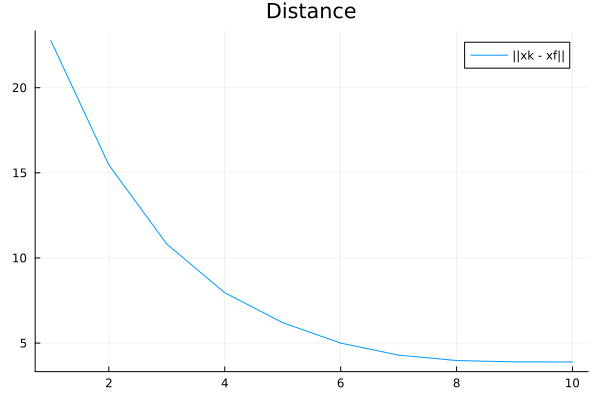

In [79]:
n1 = length(x_newton)
ydist1 = ones(n1)
for i = 1:n1
    ydist1[i] = norm(x_newton[i] - xf)
end
ylin1 = zeros(n1-1)
yquad1 = zeros(n1-1)
for i = 1:n1 -1
    ylin1[i] = ydist1[i+1] / ydist1[i]
    yquad1[i]= ydist1[i+1] / (ydist1[i]^2)
end
xdist1 = [1:n1;]
xlin1 = [1:n1-1;]
p1 = plot(xdist1, ydist1, title="Distance", label="||xk - xf||")
p2 = plot(xlin1, ylin1, title="Convergence linéaire", label = "||xk+1 - xf||/||xk - xf||" )
p3 = plot(xlin1, yquad1, title="Convergence quadratique", label = "||xk+1 - xf||/||xk - xf||²" )
plot(p1)

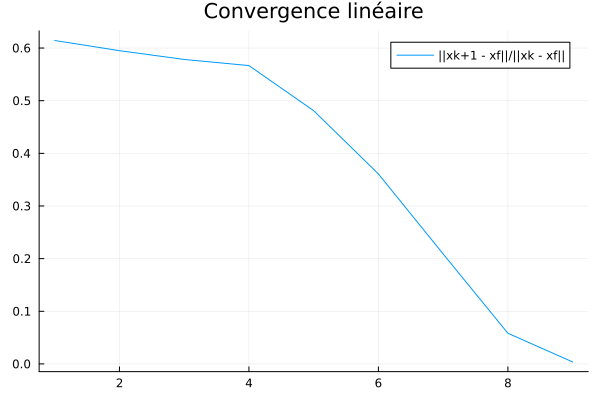

In [78]:
plot(p2)

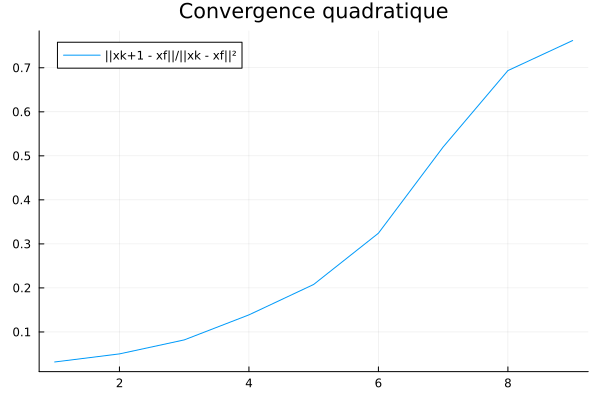

In [77]:
plot(p3)

## Methode BFGS

In [63]:
x_bfgs

18-element Vector{Vector{Float64}}:
 [10.0, 20.0]
 [4.756720633843399, -12.943546586664915]
 [4.772606027478052, -6.109214291725093]
 [4.639993867429648, -5.362016919924266]
 [4.303711085827463, -3.8995607790830196]
 [4.075529417518674, -3.1106247560062306]
 [3.8702629227131364, -2.4869588637555307]
 [3.7323018867003492, -2.1064228228101003]
 [3.6511915921011897, -1.9002468710390759]
 [3.6179743370742092, -1.825829741689893]
 [3.6082696316149927, -1.8118904803876206]
 [3.5988797713976, -1.8076861219409954]
 [3.586379083980033, -1.8160069600157513]
 [3.581202206164052, -1.8347367088130477]
 [3.58274405609598, -1.8464367853691737]
 [3.5841678462695015, -1.8482103129359126]
 [3.584421377554037, -1.848149636981784]
 [3.584428453832931, -1.848127385795475]

In [72]:
xf = [3.584428, -1.848126] # approximate solution from https://en.wikipedia.org/wiki/Himmelblau%27s_function
(fH(xf), fH(x_bfgs[end]))

(8.894376497582423e-12, 1.0812720305337285e-11)

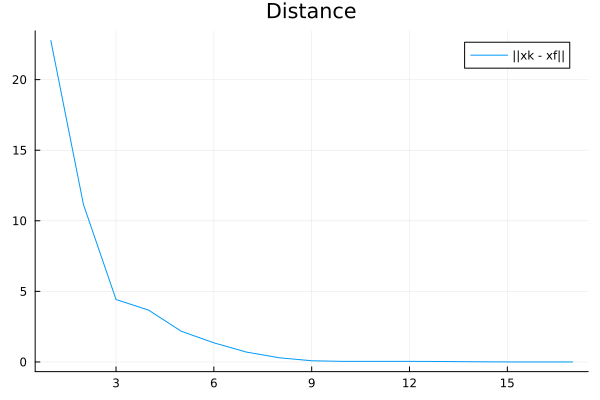

In [74]:
n2 = length(x_bfgs) - 1
ydist2 = zeros(n2)
xf = x_bfgs[end]
for i = 1:n2
    ydist2[i] = norm(x_bfgs[i] - xf)
end
ylin2 = zeros(n2-1)
yquad2 = zeros(n2-1)
for i = 1:(n2 -1)
    ylin2[i] = ydist2[i+1] / ydist2[i]
    yquad2[i]= ydist2[i+1] / (ydist2[i]^2)
end
xdist2=[1:n2;]
xlin2=[1:n2-1;]
p4=plot(xdist2, ydist2, title="Distance", label="||xk - xf||")
p5=plot(xlin2, ylin2, title="Convergence linéaire", label = "||xk+1 - xf||/||xk - xf||" )
p6=plot(xlin2, yquad2, title="Convergence quadratique", label = "||xk+1 - xf||/||xk - xf||²" )
plot(p4)

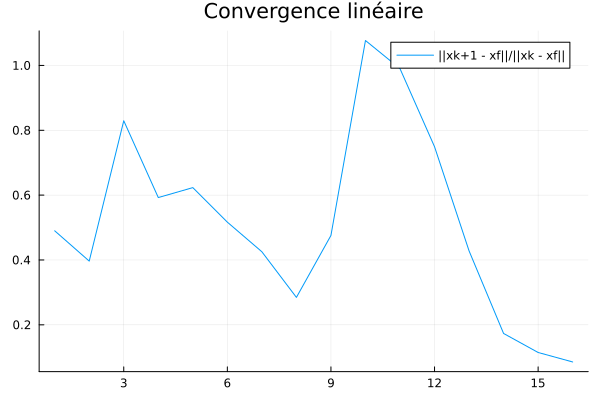

In [75]:
plot(p5)

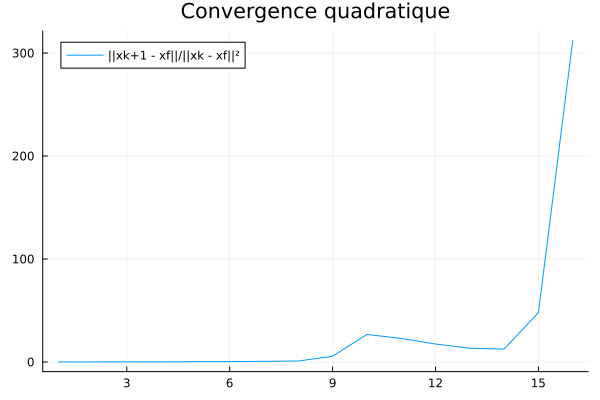

In [76]:
plot(p6)